# Exploratory Data Analysis: data understanding phase

Objectives:
* Identify missing values and determine strategy to handle the cases
* Understand the correlation matrix evaluating target against independent variables, also check if there is an indication of multicollinearity among other independent variables
* Understand distribution of target variable and independent variables (numerical) with histograms
* Validate for potential outliers and determine strategy to handle the cases, if required
* Evaluate the categorical values by doing frequency distribution and determine strategy to tackle under-represented or predominant values if required
* Drive conclusions for data preparation phase (data preprocessing)

In [104]:
import Global
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, norm
from IPython.display import display

In [7]:
config = Global.load_config()
path = Global.get_project_path(config["model"]["input_data"]["path"],0)

In [67]:
df = pd.read_csv(path)

In [66]:
display(df)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68
...,...,...,...,...,...,...,...,...,...
995,107,8.50,Clear,High,Evening,Car,13,3.0,54
996,271,16.28,Rainy,Low,Morning,Scooter,8,9.0,71
997,861,15.62,Snowy,High,Evening,Scooter,26,2.0,81
998,436,14.17,Clear,Low,Afternoon,Bike,8,0.0,55


# General information about the dataset
1. It contains 1000 records.
2. Columns are 9: 4 are categorical and 4 numerical, 1 is an ID.
3. Four columns with missing values: Weather, Traffic Level, Time_of_Day, Courier_Experience_yrs. 30 values missing for each.
4. No duplicates were found.


In [110]:
print(df.info())
print("*" * 50)
print(f"Data shape: {df.shape}")
print("*" * 50)
print(f'Checking for duplicates in the data: {df.duplicated().any()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB
None
**************************************************
Data shape: (1000, 9)
**************************************************
Checking for duplicates in the data: False


# Missing values
Data has 117 records with missing values, representing 12% of total records.

Will explore more the data to determine the strategy for missing values

In [111]:
count_with_nulls = df[['Weather', 'Traffic_Level', 'Time_of_Day', 'Courier_Experience_yrs']].isnull().any(axis=1).sum()
total_records = len(df)
print(f"Total records with missing data: {count_with_nulls}")
percentage_with_nulls = round((count_with_nulls / total_records) * 100,0)
print("*" * 50)
print(f'Percentage of missing records: {percentage_with_nulls}')

Total records with missing data: 117
**************************************************
Percentage of missing records: 12.0


# Correlation Matrix

* Spearman selected as test (better suited for real world cases with non-normal distributed data).
* When checking against target variable, the Distance_km is having a strong positive correlation: expected behavior.
* Other features which are having a positive correlation makes sense beforehand, like preparation time. It confirms that the expected features are present when leading to high delivery times.
* Courier experience appears as negative, but not strong.
* Correlation values between independent variables are low therefore not evident multicollinearity, which is positive if progressing with this case as a regression problem.

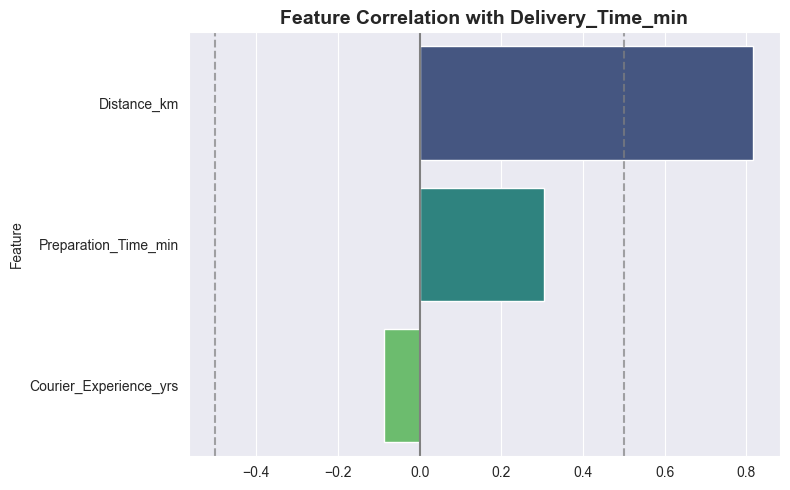

In [142]:
target_variable = 'Delivery_Time_min'

df_corr = df.drop(columns=['Order_ID'])
correlation_matrix = df_corr.corr(method='spearman', numeric_only = True)

target_corr = correlation_matrix[target_variable].drop(target_variable).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    hue=target_corr.index,
    palette=sns.color_palette("viridis", len(target_corr)),
    orient='h'
)

plt.axvline(0, color='grey', linewidth=1.5)
plt.axvline(0.5, color='grey', linestyle='--', alpha=0.7)
plt.axvline(-0.5, color='grey', linestyle='--', alpha=0.7)

plt.title(f'Feature Correlation with {target_variable}', fontsize=14, fontweight='bold')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

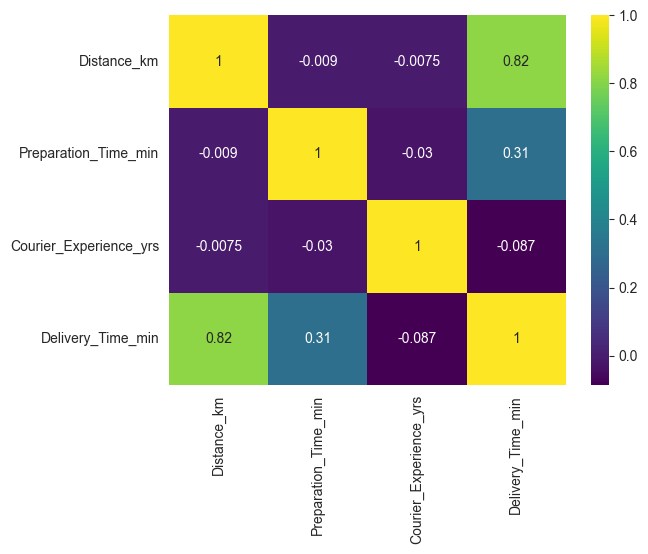

In [143]:
sns.heatmap(correlation_matrix, cmap="viridis", annot=True)
plt.show()

# Distribution of numerical columns

* Exploring the worst case scenario, delivery time MAX value is 2.7 times greater than the average; by taking the 75th percentile it is 2.15 times greater therefore an unlikely case.
* Likewise, the MIN value is 7 times less than the average, also very unlikely.
* Delivery time mean and median are very close, 56 and 55 respectively, while the standard deviation is 22, therefore very spread.
* For Delivery time, IQR lies between 41 and 71 minutes for typical cases.
* By doing the same exercise over preparation time, IQR lies between 11 and 23 minutes, way closer to the best and worst cases having 5 and 29 minutes.
* Repeating the exercise for distance, the IQR lies between 5.11 Km and 15.02 Km as potential typical cases, while not so close to the extreme values considering that MIN was 0.59 Km and MAX 20 Km.
* Courier experience has an average of 4.6 years and median is at 5 years, with 75% of total having 2 years or more of experience (high retention of delivery partners)

In [63]:
df[['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']].describe()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,970.000000,1000.000000
mean,10.059970,16.982000,4.579381,56.732000
std,5.696656,7.204553,2.914394,22.070915
min,0.590000,5.000000,0.000000,8.000000
25%,5.105000,11.000000,2.000000,41.000000
50%,10.190000,17.000000,5.000000,55.500000
75%,15.017500,23.000000,7.000000,71.000000
max,19.990000,29.000000,9.000000,153.000000


In [122]:
Q1 = df[target_variable].quantile(0.25)

Q3 = df[target_variable].quantile(0.75)

IQR = Q3 - Q1

print(f"Actual Q1 (25th Percentile): {Q1:.2f} minutes")
print(f"Actual Q3 (75th Percentile): {Q3:.2f} minutes")
print(f"Actual Interquartile Range (IQR): {IQR:.2f} minutes")
print("*" * 50)
print(f"The IQR of delivery time are between {Q1:.2f} and {Q3:.2f} minutes.")

Actual Q1 (25th Percentile): 41.00 minutes
Actual Q3 (75th Percentile): 71.00 minutes
Actual Interquartile Range (IQR): 30.00 minutes
**************************************************
The IQR of delivery time are between 41.00 and 71.00 minutes.


In [124]:
Q1 = df['Preparation_Time_min'].quantile(0.25)

Q3 = df['Preparation_Time_min'].quantile(0.75)

IQR = Q3 - Q1

print(f"Actual Q1 (25th Percentile): {Q1:.2f} minutes")
print(f"Actual Q3 (75th Percentile): {Q3:.2f} minutes")
print(f"Actual Interquartile Range (IQR): {IQR:.2f} minutes")
print("*" * 50)
print(f"The IQR of preparation time are between {Q1:.2f} and {Q3:.2f} minutes.")

Actual Q1 (25th Percentile): 11.00 minutes
Actual Q3 (75th Percentile): 23.00 minutes
Actual Interquartile Range (IQR): 12.00 minutes
**************************************************
The IQR of preparation time are between 11.00 and 23.00 minutes.


In [125]:
Q1 = df['Distance_km'].quantile(0.25)

Q3 = df['Distance_km'].quantile(0.75)

IQR = Q3 - Q1

print(f"Actual Q1 (25th Percentile): {Q1:.2f} Km")
print(f"Actual Q3 (75th Percentile): {Q3:.2f} Km")
print(f"Actual Interquartile Range (IQR): {IQR:.2f} Km")
print("*" * 50)
print(f"The IQR of distance are between {Q1:.2f} and {Q3:.2f} Km.")

Actual Q1 (25th Percentile): 5.11 km
Actual Q3 (75th Percentile): 15.02 km
Actual Interquartile Range (IQR): 9.91 km
**************************************************
The IQR of distance are between 5.11 and 15.02 km.


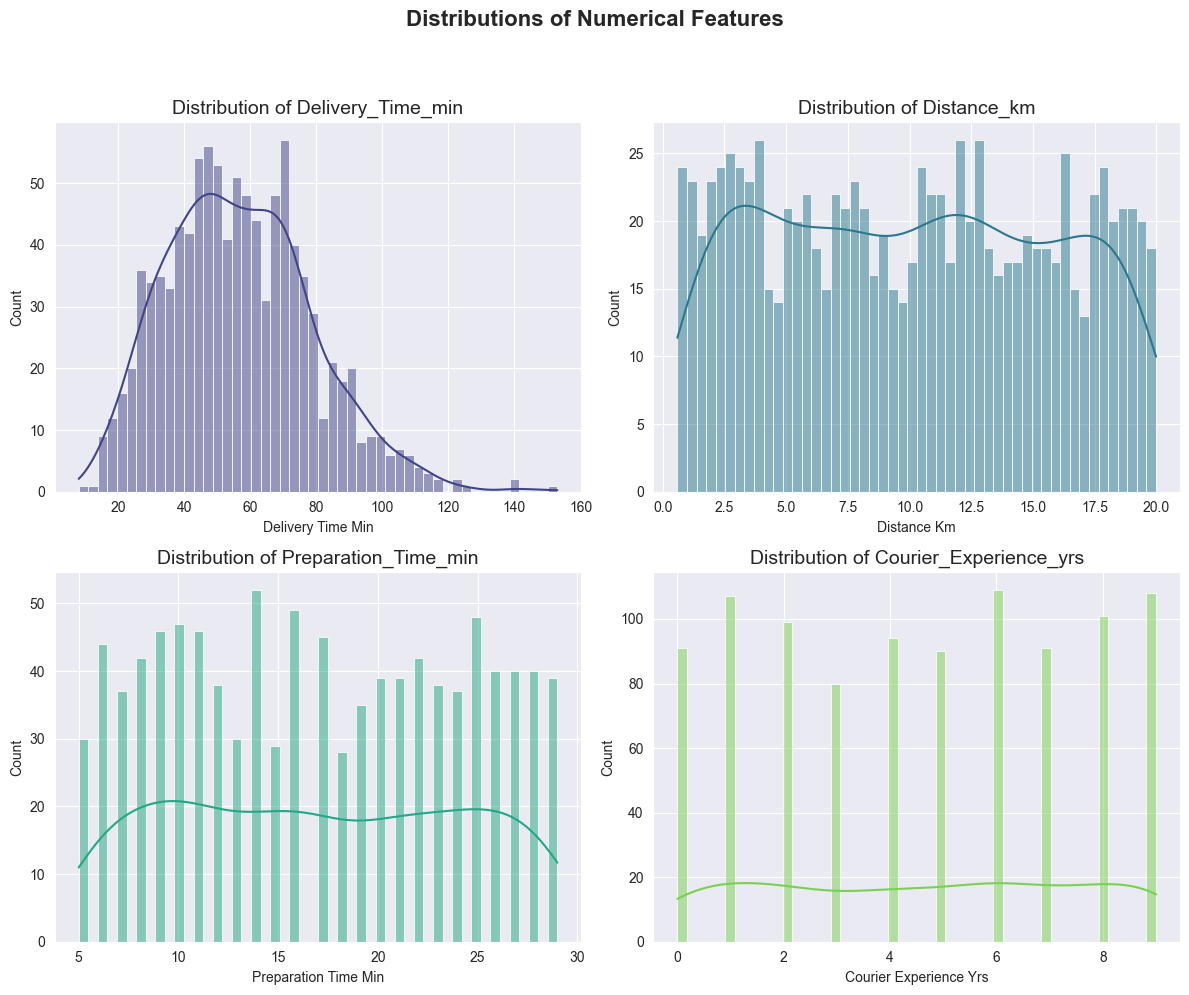

In [150]:
numerical_cols = ['Delivery_Time_min', 'Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
axes = axes.flatten()

colors = sns.color_palette("viridis", len(numerical_cols))

for i, col in enumerate(numerical_cols):
    sns.histplot(
        df[col],
        bins=50,
        kde=True,
        ax=axes[i],
        color=colors[i]
    )
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col.replace('_', ' ').title())

plt.suptitle('Distributions of Numerical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Potential anomalies

* Evaluating the target with the box plot, there are 6 cases over the upper whisker. These cases are associated with large distances (15 Km or more), sometimes combined with high preparation time and weather being rainy, regardless of a low traffic and being delivered by an experienced courier.
* As commented, these cases are very unlikely, but can't be ruled out as there are no additional sources or means to validate that they are an anomaly (e.g. wrong input).
* Consequently, these cases are underrepresented in the data, but better to keep them as they are part of the nature of the business operations, therefore the model can be evaluated considering the probability of facing such cases.

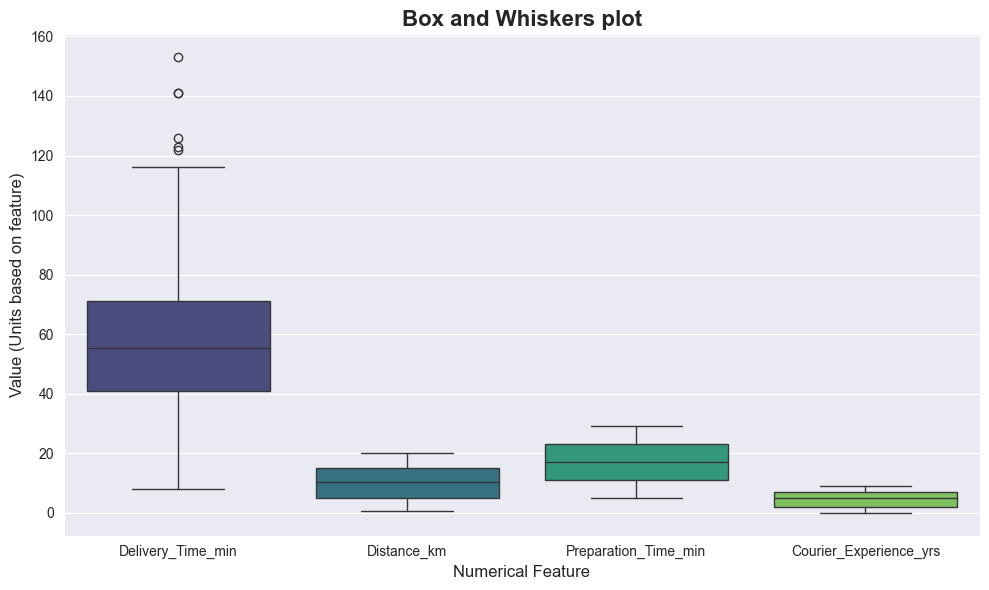

In [144]:
df_numerical = df[numerical_cols]

df_melted = df_numerical.melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Feature',
    y='Value',
    hue='Feature',
    data=df_melted,
    palette='viridis'
)

plt.title('Box and Whiskers plot', fontsize=16, fontweight='bold')
plt.xlabel('Numerical Feature', fontsize=12)
plt.ylabel('Value (Units based on feature)', fontsize=12)

plt.tight_layout()
plt.show()

In [127]:
df_filtered = df[df['Delivery_Time_min'] > 116]

# Display the first few rows of the filtered DataFrame
print(df_filtered.head())
print(f"\nTotal number of deliveries over 116 minutes (upper whisker): {len(df_filtered)}")

     Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
29        948        18.05   Clear        Medium     Evening      Scooter   
127       446        18.97   Clear           Low     Evening          Car   
379       814        18.46   Clear           NaN         NaN      Scooter   
452       394        15.64   Rainy           Low         NaN         Bike   
784       385        14.83   Rainy           Low     Morning          Car   

     Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
29                     10                     7.0                123  
127                    25                     4.0                141  
379                    29                     1.0                153  
452                    20                     4.0                141  
784                    19                     4.0                126  

Total number of deliveries over 116 minutes: 6


# Frequency distribution for categorical values

* Regarding Weather: clear and rainy are the predominant observations with 70% of total, of which clear accounts for 49%, while Foggy, Snowy and Windy are around 10% each.
* Traffic level: Medium and Low are the predominant observations, and are also very close around 40% both, while High is having 20%.
* Time of Day: Most of the orders are happening during the Morning, Afternoon and Evening with 91% in total, while only 9% occur during the nigh.
* Vehicle type: Bike appears as the most common type with 50%, followed by Scooter with 30% and then Car represents 20%.

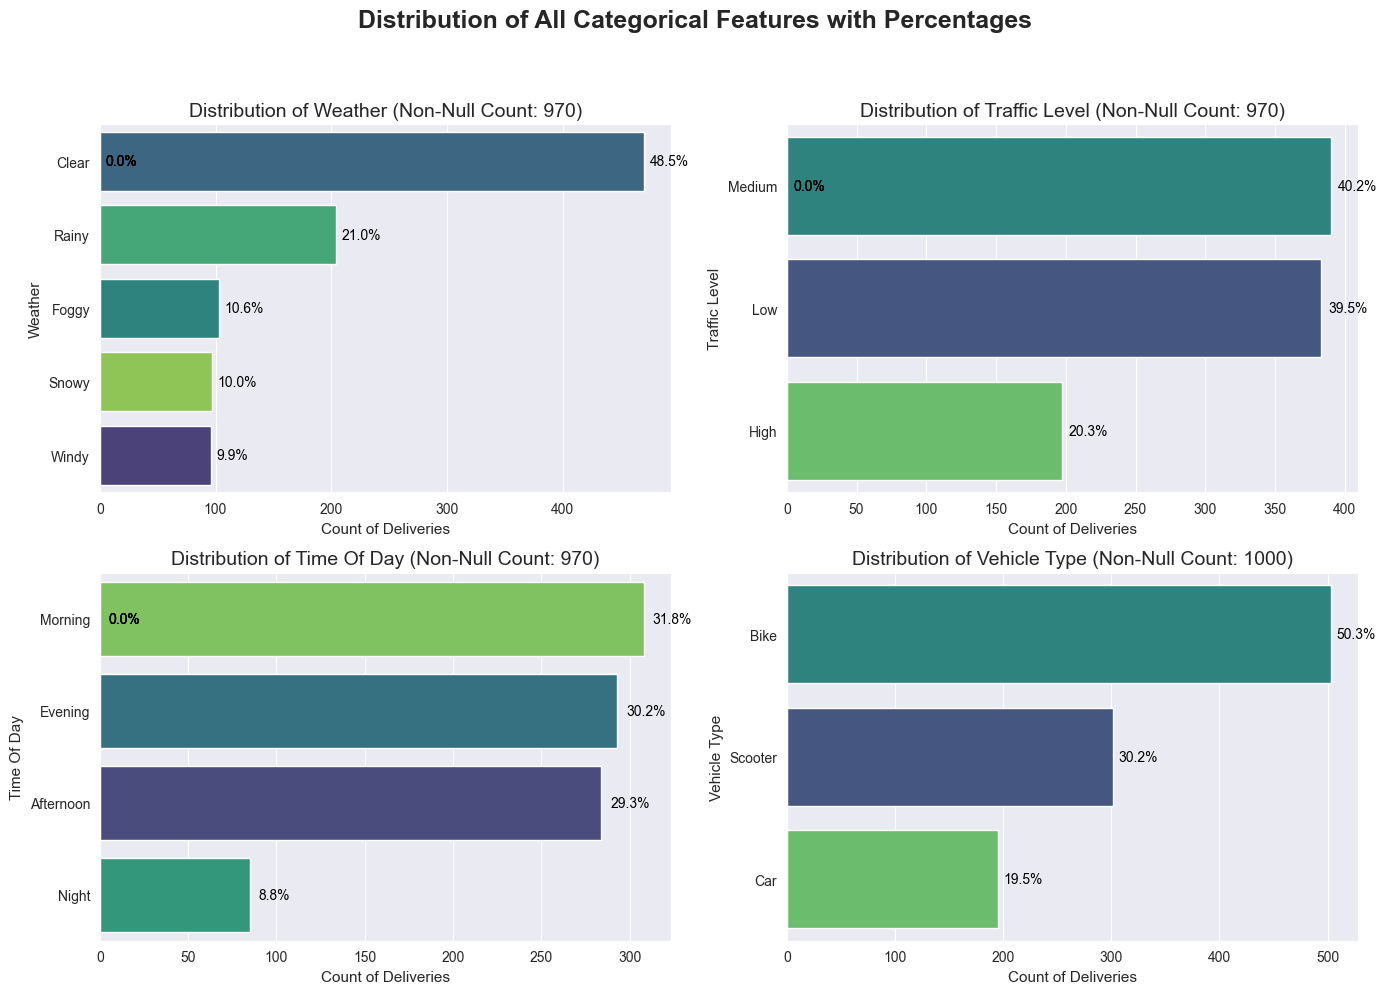

In [152]:
categorical_cols = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
axes = axes.flatten()
total_records = len(df)


for i, col in enumerate(categorical_cols):

    total_non_null = df[col].notna().sum()

    ax = sns.countplot(
        y=col,
        data=df,
        order=df[col].value_counts().index,
        hue=col,
        palette='viridis',
        ax=axes[i]
    )

    for p in ax.patches:
        count = p.get_width()

        percentage = 100 * count / total_non_null

        x_loc = count + (total_records * 0.005)
        y_loc = p.get_y() + p.get_height() / 2

        ax.annotate(
            f'{percentage:.1f}%',
            xy=(x_loc, y_loc),
            ha='left',
            va='center',
            fontsize=10,
            color='black'
        )

    ax.set_title(f'Distribution of {col.replace("_", " ").title()} (Non-Null Count: {total_non_null})', fontsize=14)
    ax.set_xlabel('Count of Deliveries', fontsize=11)
    ax.set_ylabel(col.replace("_", " ").title(), fontsize=11)

    if ax.legend_:
        ax.legend_.remove()


plt.suptitle('Distribution of All Categorical Features with Percentages', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Final Remarks and conclusions for data preparation and modeling

* After checking the categorical values more in details, one option for the missing values is that a flag is created when value is unknown, therefore allowing it as an additional category, that, while underrepresented, can replicate what can occur while in production, where same issue might rise. Also, it is preferred to avoid filling missing based on current proportion of values by category, as this might introduce bias to the training data.
* About the anomalies, as commented, these cases are very unlikely, but can't be ruled out as there are no additional sources or means to validate that they are an anomaly (e.g. wrong input).
* Consequently, these cases are underrepresented in the data, but better to keep them as they are part of the nature of the business operations, therefore the model can be evaluated considering the probability of facing such cases.
* About courier experience years missing values, given the low correlation with the target and very centered data, with a median of 5 years and 75% of total courier over 2 years of courier partners, this value might work to fill the missing.
* ## **Finally, about modeling, the following finding could lead to a strategy of experimenting with models by weather: Weather Clear has 4% less average delivery time compared to Windy, 12% to 13% less compared to Foggy and Rainy which are both very close in average delivery time and 26% less average delivery time compared to Snowy.**

Text(0.5, 1.02, 'Distance Impact on Delivery Time')

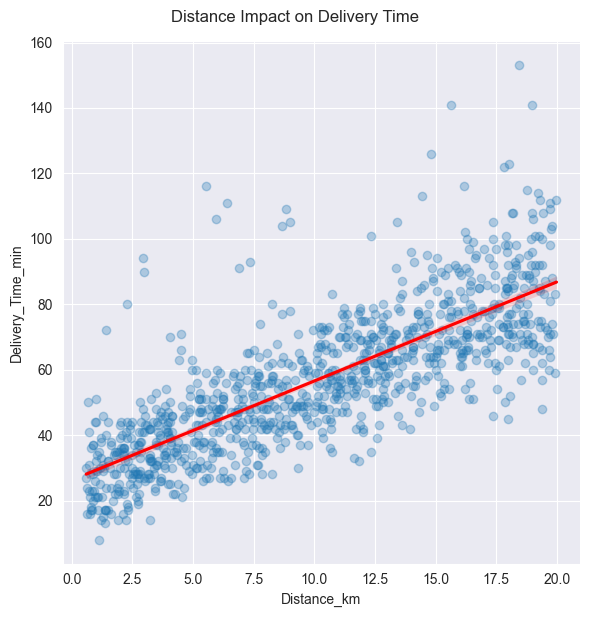

In [28]:
sns.lmplot(
    data=df,
    x='Distance_km',
    y='Delivery_Time_min',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3},
    height=6
)
plt.suptitle('Distance Impact on Delivery Time', y=1.02)

Text(0.5, 1.02, 'Preparation time Impact on Delivery Time')

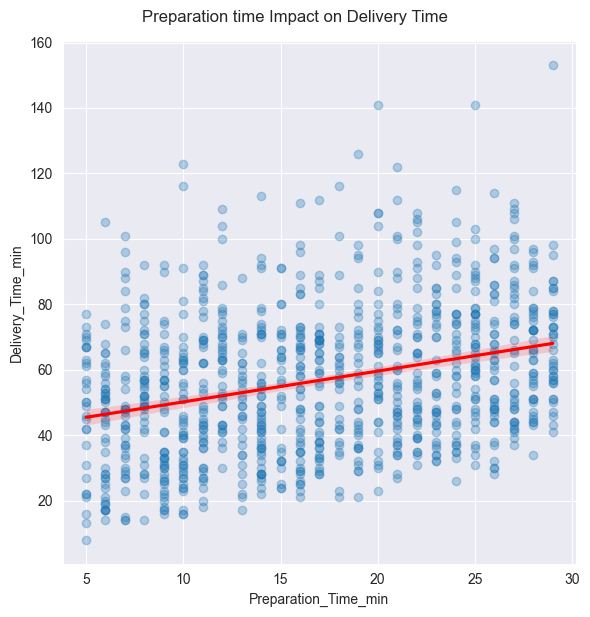

In [169]:
sns.lmplot(
    data=df,
    x='Preparation_Time_min',
    y='Delivery_Time_min',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3},
    height=6
)
plt.suptitle('Preparation time Impact on Delivery Time', y=1.02)

In [133]:
slope, intercept, r_value, p_value, std_err = linregress(
    df['Preparation_Time_min'],
    df['Delivery_Time_min']
)

print(f"Slope (B1): {slope:.3f}")
print(f"R-squared (R^2): {r_value**2:.3f}")
print(f"Y-Intercept (B0): {intercept:.3f}")

Slope (B1): 0.942
R-squared (R^2): 0.094
Y-Intercept (B0): 40.742


Text(0.5, 1.02, 'Courier experience Impact on Delivery Time')

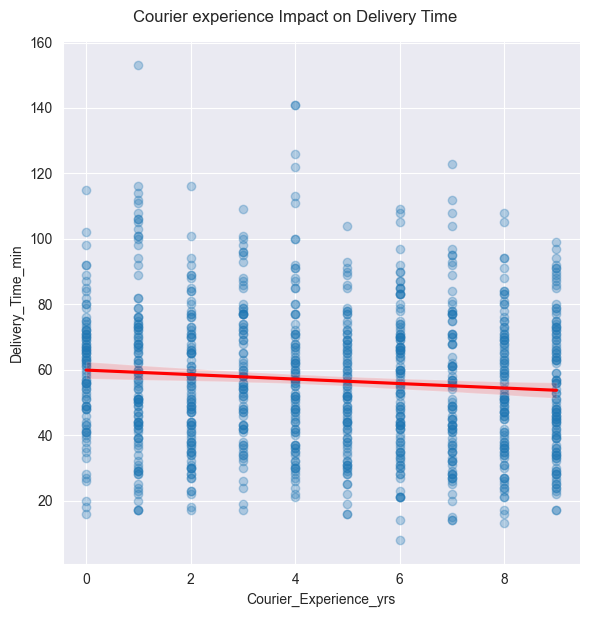

In [170]:
sns.lmplot(
    data=df,
    x='Courier_Experience_yrs',
    y='Delivery_Time_min',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3},
    height=6
)
plt.suptitle('Courier experience Impact on Delivery Time', y=1.02)

Text(0.5, 1.02, 'Distance Impact on Delivery Time Across Traffic Levels')

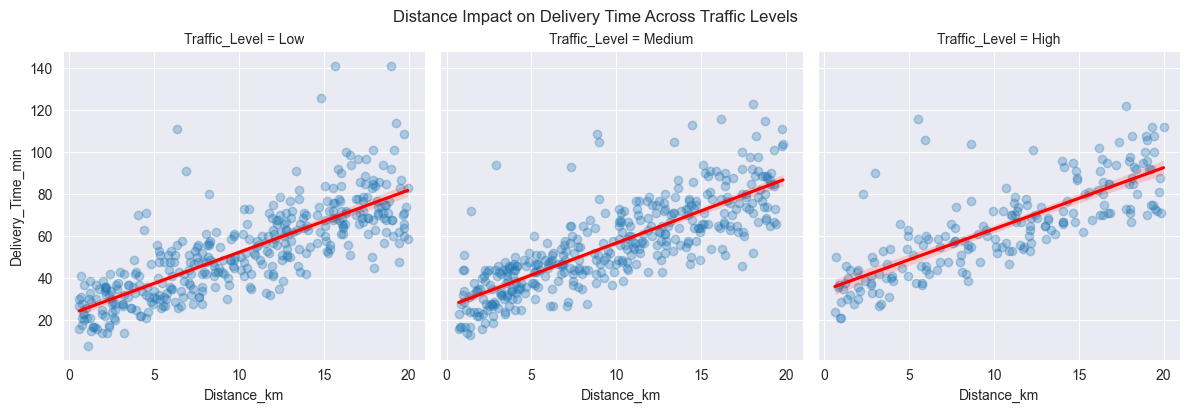

In [11]:
sns.lmplot(
    data=df,
    x='Distance_km',
    y='Delivery_Time_min',
    col='Traffic_Level',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3},
    height=4
)
plt.suptitle('Distance Impact on Delivery Time Across Traffic Levels', y=1.02)

Text(0.5, 1.02, 'Distance Impact on Delivery Time Across Weather')

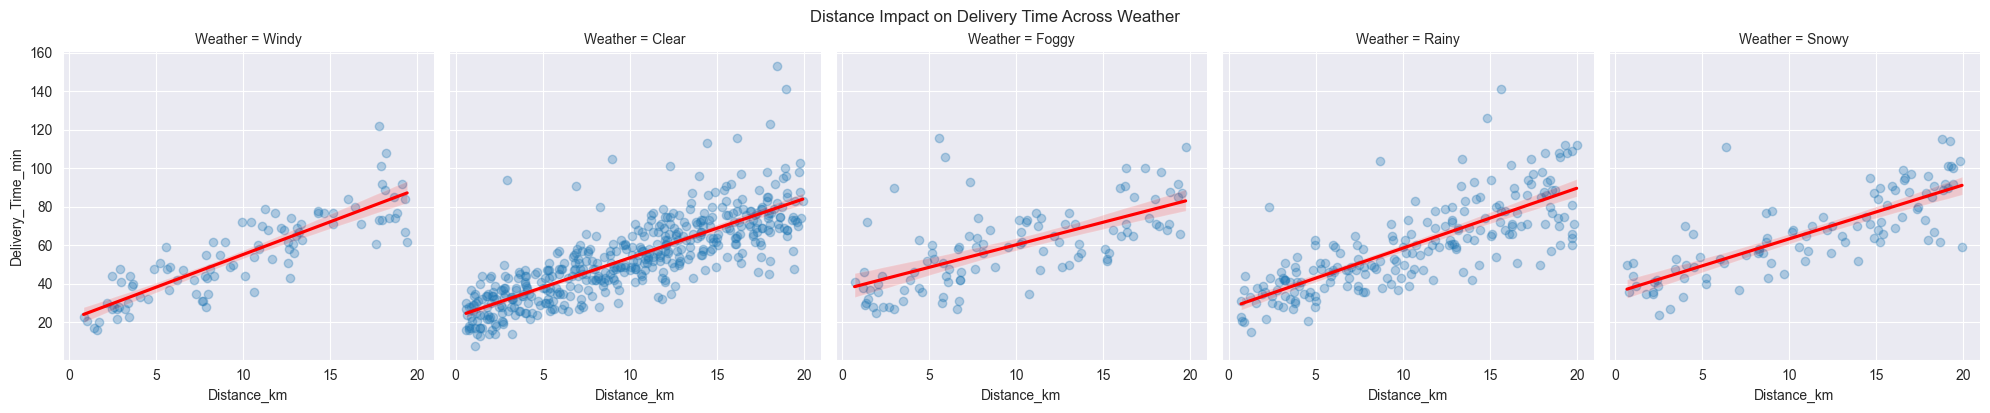

In [15]:
sns.lmplot(
    data=df,
    x='Distance_km',
    y='Delivery_Time_min',
    col='Weather',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3},
    height=4
)
plt.suptitle('Distance Impact on Delivery Time Across Weather', y=1.02)

Text(0.5, 1.02, 'Distance Impact on Delivery Time Across Weather')

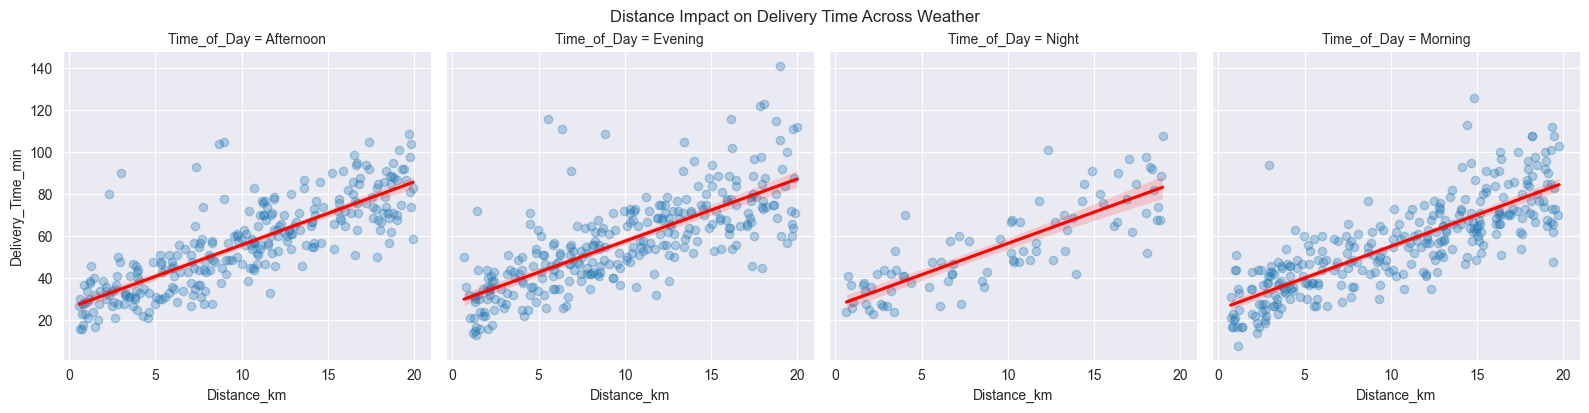

In [165]:
sns.lmplot(
    data=df,
    x='Distance_km',
    y='Delivery_Time_min',
    col='Time_of_Day',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3},
    height=4
)
plt.suptitle('Distance Impact on Delivery Time Across Weather', y=1.02)

Text(0.5, 1.02, 'Distance Impact on Delivery Time Across Weather')

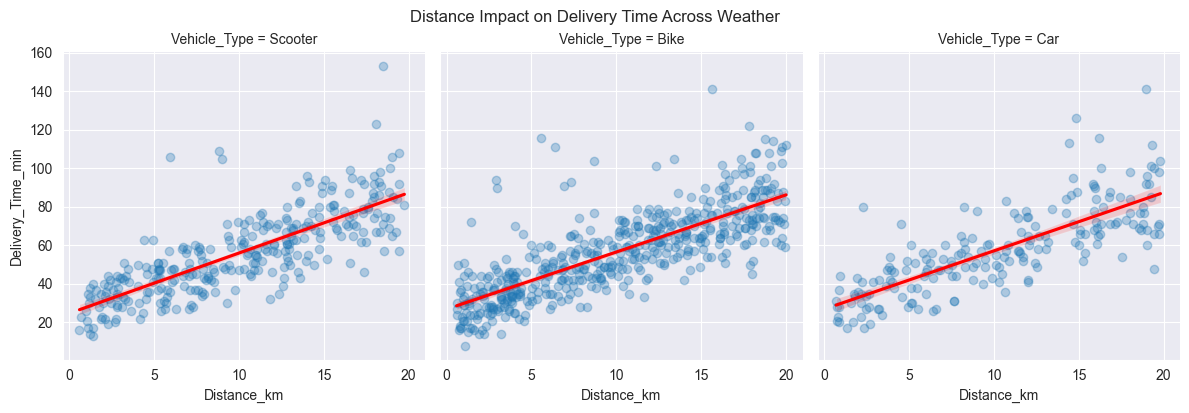

In [166]:
sns.lmplot(
    data=df,
    x='Distance_km',
    y='Delivery_Time_min',
    col='Vehicle_Type',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3},
    height=4
)
plt.suptitle('Distance Impact on Delivery Time Across Weather', y=1.02)

Text(0.5, 1.02, 'Delivery Time Distribution by Traffic, Time, and Weather')

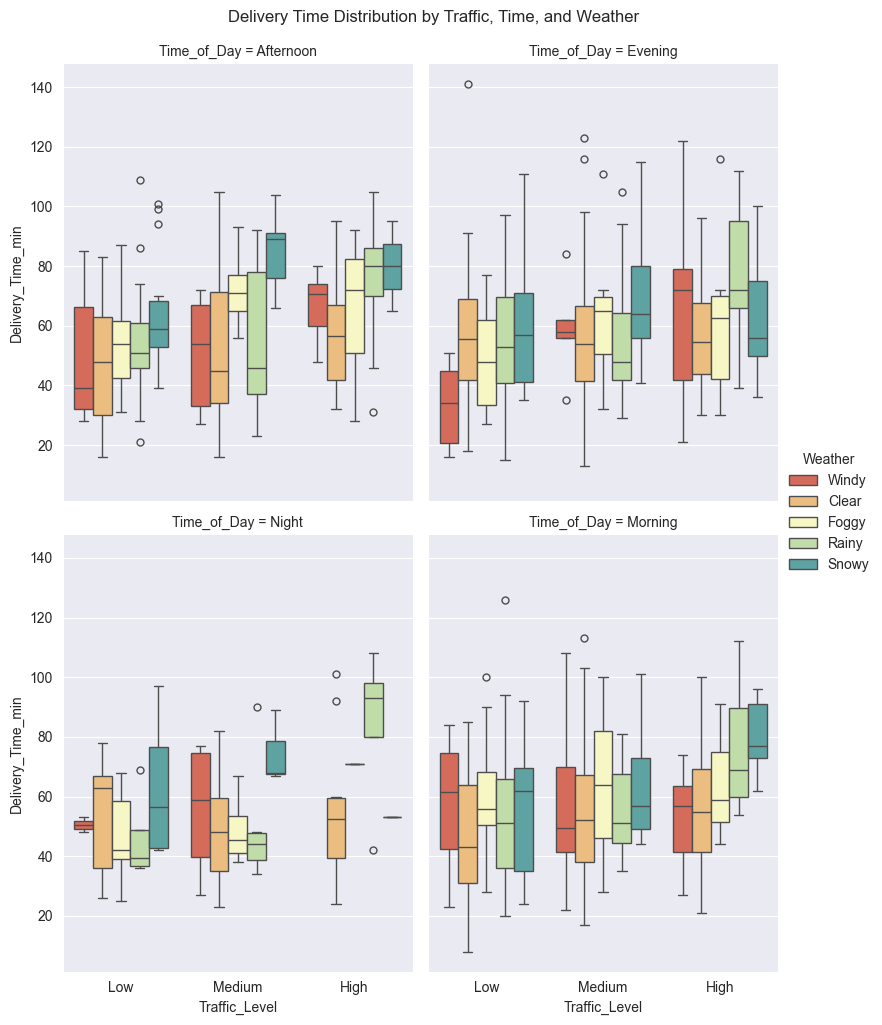

In [147]:

sns.catplot(
    data=df,
    x='Traffic_Level',
    y='Delivery_Time_min',
    kind='box',
    col='Time_of_Day',
    hue='Weather',
    palette='Spectral',
    aspect=0.8,
    col_wrap=2
)
plt.suptitle('Delivery Time Distribution by Traffic, Time, and Weather', y=1.02)

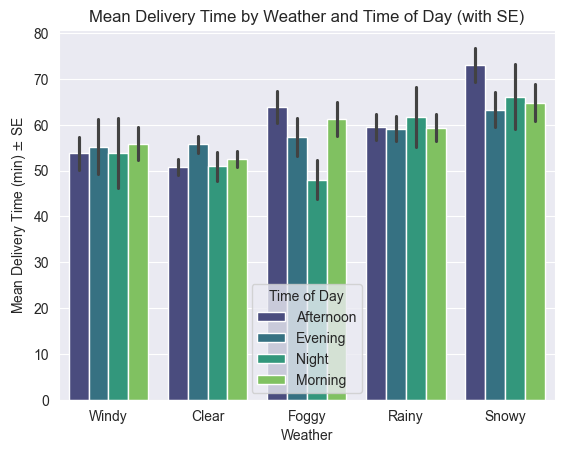

In [171]:
sns.barplot(
    data=df,
    x='Weather',
    y='Delivery_Time_min',
    hue='Time_of_Day',
    errorbar='se',
    palette='viridis'
)
plt.title('Mean Delivery Time by Weather and Time of Day (with Stdev)')
plt.ylabel(r'Mean Delivery Time (min) $\pm$ Stdev')
plt.legend(title='Time of Day')

Traffic_Level
High     64.81
Medium   56.02
Low      52.89


Text(0, 0.5, 'Mean Delivery Time $\\pm$ Stdev')

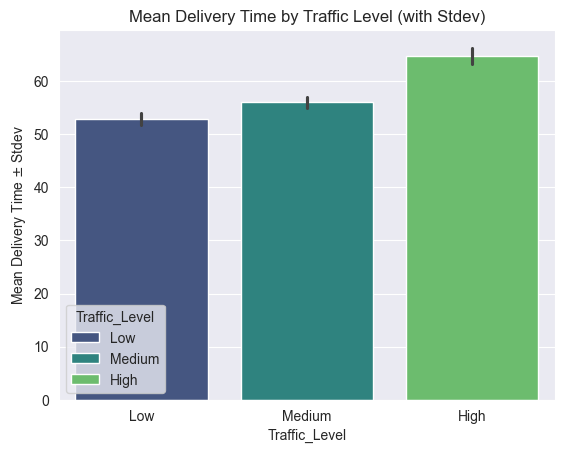

In [181]:
mean_delivery_time = df.groupby('Traffic_Level')['Delivery_Time_min'].mean()
print(mean_delivery_time.sort_values(ascending=False).to_string(float_format="%.2f"))

sns.barplot(
    data=df,
    x='Traffic_Level',
    y='Delivery_Time_min',
    hue='Traffic_Level',
    errorbar='se',
    palette='viridis'
)
plt.title('Mean Delivery Time by Traffic Level (with Stdev)')
plt.ylabel(r'Mean Delivery Time $\pm$ Stdev')

Weather
Snowy   67.11
Rainy   59.79
Foggy   59.47
Windy   55.46
Clear   53.08


Text(0, 0.5, 'Mean Delivery Time $\\pm$ Stdev')

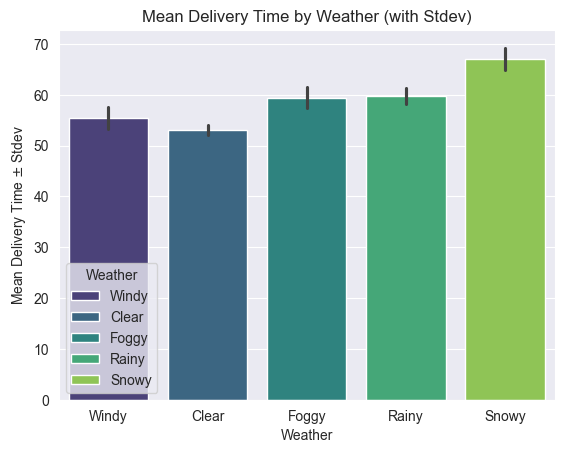

In [180]:
mean_delivery_time = df.groupby('Weather')['Delivery_Time_min'].mean()
print(mean_delivery_time.sort_values(ascending=False).to_string(float_format="%.2f"))

sns.barplot(
    data=df,
    x='Weather',
    y='Delivery_Time_min',
    hue='Weather',
    errorbar='se',
    palette='viridis'
)
plt.title('Mean Delivery Time by Weather (with Stdev)')
plt.ylabel(r'Mean Delivery Time $\pm$ Stdev')

Time_of_Day
Evening     57.48
Morning     56.12
Afternoon   56.08
Night       55.21


Text(0, 0.5, 'Mean Delivery Time $\\pm$ Stdev')

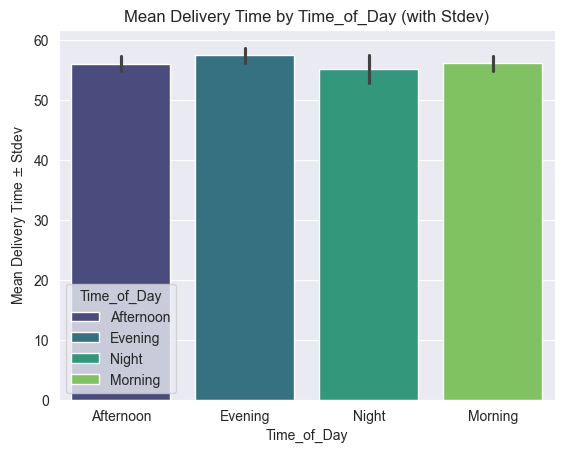

In [182]:
mean_delivery_time = df.groupby('Time_of_Day')['Delivery_Time_min'].mean()
print(mean_delivery_time.sort_values(ascending=False).to_string(float_format="%.2f"))

sns.barplot(
    data=df,
    x='Time_of_Day',
    y='Delivery_Time_min',
    hue='Time_of_Day',
    errorbar='se',
    palette='viridis'
)
plt.title('Mean Delivery Time by Time_of_Day (with Stdev)')
plt.ylabel(r'Mean Delivery Time $\pm$ Stdev')

Vehicle_Type
Car       58.20
Bike      56.57
Scooter   56.05


Text(0, 0.5, 'Mean Delivery Time $\\pm$ Stdev')

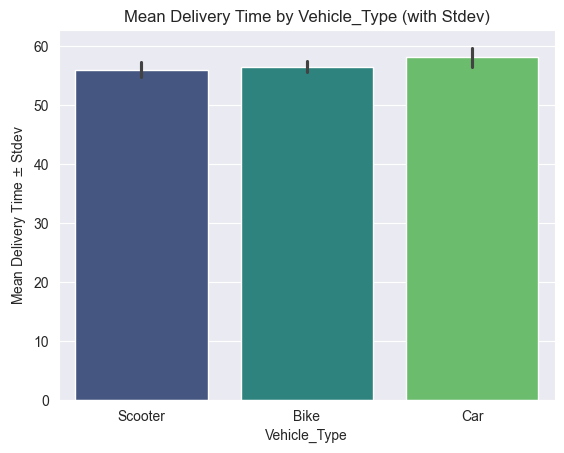

In [183]:
mean_delivery_time = df.groupby('Vehicle_Type')['Delivery_Time_min'].mean()
print(mean_delivery_time.sort_values(ascending=False).to_string(float_format="%.2f"))

sns.barplot(
    data=df,
    x='Vehicle_Type',
    y='Delivery_Time_min',
    hue='Vehicle_Type',
    errorbar='se',
    palette='viridis'
)
plt.title('Mean Delivery Time by Vehicle_Type (with Stdev)')
plt.ylabel(r'Mean Delivery Time $\pm$ Stdev')